<a href="https://colab.research.google.com/github/kikifana/Team_1_WeLead/blob/main/D02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
import os

# Define a directory to save plots
plot_dir = "model_plots"
os.makedirs(plot_dir, exist_ok=True)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
xlsx_path = '/content/drive/MyDrive/mpg.data.xlsx'
csv_path = '/content/drive/MyDrive/mpg_data.csv'

df = pd.read_excel(xlsx_path, engine='openpyxl')

df.to_csv(csv_path, index=False)

print(f"CSV file saved at: {csv_path}")

CSV file saved at: /content/drive/MyDrive/mpg_data.csv


Drop empty columns: Unnamed: 9 - Unnamed: 12
Drop NaNs from mpg and horsepower columns. There are very few NaNs so dropping them will not be a problem.

In [ ]:
df = df.drop(columns=['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'], errors='ignore')
df = df.dropna(subset=['mpg', 'horsepower'])

Clean the car name column and extract brand names, then get the known brands so we can check for misspelled words. We then extract the brand name and also keep two-word brands such as Mercedes-Benz. We define the brand corrections for misspellings and abbreviations

In [ ]:
df['car name'] = df['car name'].str.replace(r'\s+', ' ', regex=True).str.strip()

known_brands = ["mercedes benz", "chevrolet", "ford", "buick", "plymouth",
    "volkswagen", "peugeot", "audi", "saab", "bmw", "toyota", "mazda", "pontiac",
    "mercury", "nissan", "honda", "subaru", "chrysler", "dodge", "fiat", "opel", "renault"]

def extract_brand(name):
    words = name.split()
    two_word_brand = " ".join(words[:2]).lower()
    if two_word_brand in known_brands:
        return two_word_brand
    return words[0].lower()

df['car_name_merge'] = df['car name'].apply(extract_brand)

# Define brand corrections
brand_corrections = {
    "mercedes": "mercedes-benz",
    "vw": "volkswagen",
    "chevy": "chevrolet",
    "toyouta": "toyota",
    "chevroelt": "chevrolet",
    "maxda": "mazda",
    "vokswagen": "volkswagen",
    "capri": "mercury",
    "datsun": "nissan"
}

df["car_name_merge"] = df["car_name_merge"].replace(brand_corrections)

# Drop "car name" column since it's not needed anymore
df = df.drop(columns=["car name"])




In [ ]:
df = df[df["car_name_merge"] != "hi"]
print("hi 1200d' entry has been successfully removed.")

hi 1200d' entry has been successfully removed.


In [ ]:
print(df["car_name_merge"].value_counts())

car_name_merge
ford             48
chevrolet        47
plymouth         31
dodge            28
amc              27
toyota           26
nissan           24
volkswagen       22
buick            17
pontiac          16
honda            13
mazda            12
mercury          12
oldsmobile       10
fiat              8
peugeot           8
audi              7
chrysler          6
volvo             6
saab              4
opel              4
subaru            4
renault           3
bmw               2
mercedes-benz     2
cadillac          2
mercedes benz     1
triumph           1
Name: count, dtype: int64


We continue our analysis with two different ways.
1. Calculating manually MPG clusters based on observations of the mpg's histogram.
2. KMeans Clustering. We looped from 2 to 5 and found the elbow in k = 3

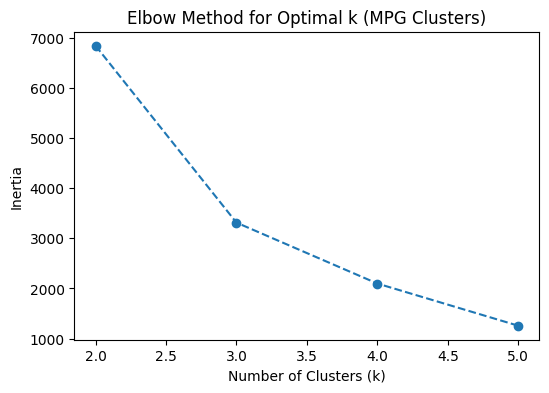

In [ ]:
# Manual MPG Clustering --- based on the histogram of mpg
bins = [0, 20, 30, max(df['mpg'].max(), 50)]
labels = ['Low', 'Medium', 'High']
df['mpg_cluster'] = pd.cut(df['mpg'], bins=bins, labels=labels)

# KMeans Clustering - Find best k using Elbow Method
inertia = []
K_range = range(2, 6)  # Testing k from 2 to 5

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df[['mpg']])
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia, marker='o', linestyle='dashed')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (MPG Clusters)')
plt.show()

# Select optimal k manually
optimal_k = 3
df['mpg_kmeans'] = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit_predict(df[['mpg']])
df = df.drop(columns=['mpg'])  # Drop actual MPG after clustering


The function preprocess_features:
1. Choose between standard scaling or min max scaling
2. Apply One Hot Encoding to car_name_merge, cylinders, origin columns
3. Apply the chosen scaler in the rest features that are not one hot encoded.


In [ ]:
def preprocess_features(df, scale_method="standard"):

    categorical_columns = ["car_name_merge", "cylinders", "origin"]
    existing_categoricals = [col for col in categorical_columns if col in df.columns]

    if existing_categoricals:
        df = pd.get_dummies(df, columns=existing_categoricals, drop_first=True)

    num_features = ['displayments', 'horsepower', 'weight', 'acceleration', 'model year']
    existing_num_features = [col for col in num_features if col in df.columns]

    # Choose Standard or MinMax Scaler
    if scale_method == "standard":
        scaler = StandardScaler()
    elif scale_method == "minmax":
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scale_method. Choose 'standard' or 'minmax'.")

    if existing_num_features:
        df[existing_num_features] = scaler.fit_transform(df[existing_num_features])

    return df





In [ ]:
# Standard Scaled Dataset
df_standard_scaled = preprocess_features(df.copy(), scale_method="standard")

# Min-Max Scaled Dataset
df_minmax_scaled = preprocess_features(df.copy(), scale_method="minmax")



We split the two datasets (min-max dataset and standard dataset) using train_test_split().

In [ ]:
# Splitting Standard Scaled Data
X_standard = df_standard_scaled.drop(columns=['mpg_cluster', 'mpg_kmeans'])
y_manual_standard = df_standard_scaled['mpg_cluster']
y_kmeans_standard = df_standard_scaled['mpg_kmeans']

X_train_manual_std, X_test_manual_std, y_train_manual_std, y_test_manual_std = train_test_split(
    X_standard, y_manual_standard, test_size=0.2, random_state=42, stratify=y_manual_standard
)
X_train_kmeans_std, X_test_kmeans_std, y_train_kmeans_std, y_test_kmeans_std = train_test_split(
    X_standard, y_kmeans_standard, test_size=0.2, random_state=42, stratify=y_kmeans_standard
)

# Splitting MinMax Scaled Data
X_minmax = df_minmax_scaled.drop(columns=['mpg_cluster', 'mpg_kmeans'])
y_manual_minmax = df_minmax_scaled['mpg_cluster']
y_kmeans_minmax = df_minmax_scaled['mpg_kmeans']

X_train_manual_mm, X_test_manual_mm, y_train_manual_mm, y_test_manual_mm = train_test_split(
    X_minmax, y_manual_minmax, test_size=0.2, random_state=42, stratify=y_manual_minmax
)
X_train_kmeans_mm, X_test_kmeans_mm, y_train_kmeans_mm, y_test_kmeans_mm = train_test_split(
    X_minmax, y_kmeans_minmax, test_size=0.2, random_state=42, stratify=y_kmeans_minmax
)
